In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve
import matplotlib.pyplot as plt
from integrators import IntegratorConfig, symplectic_integrator, flow_integrator, rk_integrator

jax.config.update("jax_enable_x64", True)


In [2]:
def lagrangian(q, v):
    q3 = q.reshape(-1, 2)
    v3 = v.reshape(-1, 2)
    mass = jnp.array([1.0, 2.0, 3.0])
    i, j = jnp.tril_indices_from(q3, -1)
    distance = jnp.sqrt(jnp.sum((q3[i] - q3[j]) ** 2, axis=-1))
    return 0.5 * jnp.sum(mass[:, None] * v3 * v3) + jnp.sum(
        mass[i] * mass[j] / distance
    )


def hamiltonian_from_lagrangian(state):
    q, p = state
    # invert the fiber derivative
    v = solve(jax.jacobian(jax.jacobian(lambda v: lagrangian(q, v)))(jnp.ones(6)), p)
    return p @ v - lagrangian(q, v)



def kinetic_energy(state, mass):
    _, p = state
    p3 = p.reshape(-1, 2)
    return 0.5 * jnp.sum(p3 * p3 / mass[:, None])


def potential_energy(state, mass):
    q, _ = state
    q3 = q.reshape(-1, 2)
    i, j = jnp.tril_indices_from(q3, -1)
    invdistance = jnp.pow(jnp.sum((q3[i] - q3[j]) ** 2, axis=-1), -0.5)
    return -jnp.sum(mass[i] * mass[j] * invdistance)


def hamiltonian(state, mass):
    return kinetic_energy(state, mass) + potential_energy(state, mass)

In [3]:
q0 = jnp.array([0.0, 1.0, 1.0, 0.0, -1.0, 0.0])
p0 = jnp.zeros(6)
state0 = jnp.array((q0, p0))
mass0 = jnp.array([1.0, 2.0, 3.0])


# much more fun
# state0 = jnp.array(
#     [
#         [
#             0.6733224710678404,
#             0.0006444390845759389,
#             -0.10733177312062013,
#             -0.06875982027365993,
#             -0.48621964160889125,
#             0.3789584004876191,
#         ],
#         [
#             3.6177035896412204,
#             -0.5416124691063872,
#             -2.475260691714918,
#             0.970244850494132,
#             -1.1424428979263148,
#             -0.428632381387655,
#         ],
#     ]
# )

dt = 2e-4
Nsteps = 50000
times = jnp.linspace(0, Nsteps * dt, Nsteps)

In [4]:
def hamiltonian_mass0(state):
    return hamiltonian(state, mass0)

h0, dstate_dh = jax.vjp(hamiltonian_mass0, state0)
(co_state,) = dstate_dh(1.0)


def omega(v_state):
    """Symplectic form (maps tangent space to cotangent space)"""
    return jnp.array((-v_state[1], v_state[0]))


def Omega(co_state):
    """Symplectic form inverse (maps cotangent space to tangent space)"""
    return jnp.array((co_state[1], -co_state[0]))


# inverse symplectic form map gives us the Hamiltonian vector field
v_state = Omega(co_state)
h0prime, dh_dstate = jax.jvp(hamiltonian_mass0, (state0,), (v_state,))

assert jnp.allclose(h0, h0prime)
# this confirms that the Hamiltonian and symplectic form are in a consistent basis
assert jnp.allclose(dh_dstate, jnp.zeros(1))

In [5]:
def Xh(h, state):
    _, dstate_dh = jax.vjp(h, state)
    (co_state,) = dstate_dh(1.0)
    return Omega(co_state)


Xh(hamiltonian_mass0, state0)

Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.35355339, -1.76776695, -2.20710678,  0.70710678,  2.56066017,
         1.06066017]], dtype=float64)

In [6]:
Omega(jax.jacobian(hamiltonian_mass0)(state0))

Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.35355339, -1.76776695, -2.20710678,  0.70710678,  2.56066017,
         1.06066017]], dtype=float64)

In [7]:
leapfrog_config = IntegratorConfig((1, 0), (0, 1))
q, p, H = symplectic_integrator(hamiltonian_mass0, state0, times, leapfrog_config)
leapfrog_track = jnp.array((q, p))
leapfrog_energy = H

verlet2_config = IntegratorConfig((0, 1), (0.5, 0.5))
q, p, H = symplectic_integrator(hamiltonian_mass0, state0, times, verlet2_config)
verlet2_track = jnp.array((q, p))
verlet2_energy = H

# https://cds.cern.ch/record/143981/files/cer-000055082.pdf
ruth3_config = IntegratorConfig((1, -2 / 3, 2 / 3), (-1 / 24, 3 / 4, 7 / 24))
q, p, H = symplectic_integrator(hamiltonian_mass0, state0, times, ruth3_config)
ruth3_track = jnp.array((q, p))
ruth3_energy = H


def make_yoshida4():
    x0 = -(2 ** (1 / 3)) / (2 - 2 ** (1 / 3))
    x1 = 1 / (2 - 2 ** (1 / 3))
    c1c4 = x1 / 2
    c2c3 = (x1 + x0) / 2
    d1d3 = x1
    d2 = x0
    return IntegratorConfig(
        c=(c1c4, c2c3, c2c3, c1c4),
        d=(d1d3, d2, d1d3, 0.0),
    )


yoshida4_config = make_yoshida4()
q, p, H = symplectic_integrator(hamiltonian_mass0, state0, times, yoshida4_config)
yoshida4_track = jnp.array((q, p))
yoshida4_energy = H

/Users/ncsmith/src/beamline/integrators.py:22: UserWarning: Failed to satisfy the symplectic condition at second order for IntegratorConfig(c=(1, 0), d=(0, 1))
  warnings.warn(
/Users/ncsmith/src/beamline/integrators.py:32: UserWarning: Failed to satisfy symmetric condition for IntegratorConfig(c=(1, -0.6666666666666666, 0.6666666666666666), d=(-0.041666666666666664, 0.75, 0.2916666666666667))
  warnings.warn(f"Failed to satisfy symmetric condition for {self}")


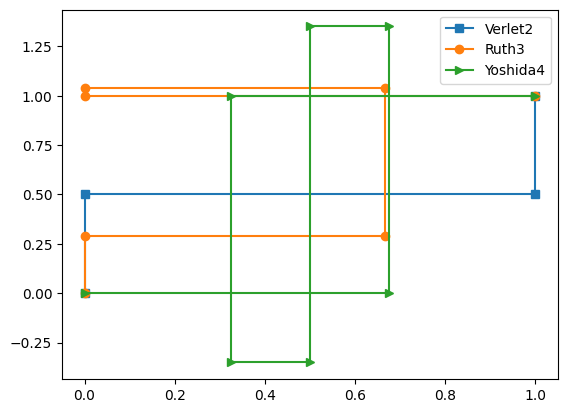

In [8]:
fig, ax = plt.subplots()

ax.plot(*verlet2_config.steps().T, marker="s", label="Verlet2")
ax.plot(*ruth3_config.steps().T, marker="o", label="Ruth3")
ax.plot(*yoshida4_config.steps().T, marker=">", label="Yoshida4")

ax.legend()

In [9]:
q, p, H, flow = flow_integrator(hamiltonian_mass0, state0, times)
flow2_track = jnp.array((q, p))
flow2_energy = H

In [10]:
q, p, H = rk_integrator(hamiltonian_mass0, state0, times)
rk_track = jnp.array((q, p))
rk_energy = H

In [11]:
%timeit symplectic_integrator(hamiltonian_mass0, state0, times, ruth3_config)
%timeit rk_integrator(hamiltonian_mass0, state0, times)

13.4 ms ± 59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.94 ms ± 64.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


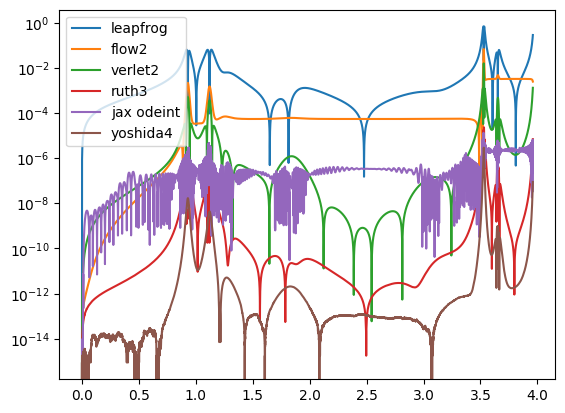

In [12]:
fig, ax = plt.subplots()

H0 = hamiltonian_mass0(state0)
# ax.axhline(H0, color="k", linestyle=":", label="initial energy")
cut = slice(0, 19800)
ax.plot(times[cut], abs(leapfrog_energy[cut] - H0), label="leapfrog")
ax.plot(times[cut], abs(flow2_energy[cut] - H0), label="flow2")
ax.plot(times[cut], abs(verlet2_energy[cut] - H0), label="verlet2")
ax.plot(times[cut], abs(ruth3_energy[cut] - H0), label="ruth3")
ax.plot(times[cut], abs(rk_energy[cut] - H0), label="jax odeint")
ax.plot(times[cut], abs(yoshida4_energy[cut] - H0), label="yoshida4")
# a potential measure of the error in the flow?
# ax.plot(times[cut], jnp.log(jnp.abs(flow[cut] * dt)), label="flow")

ax.set_yscale("log")
ax.legend()

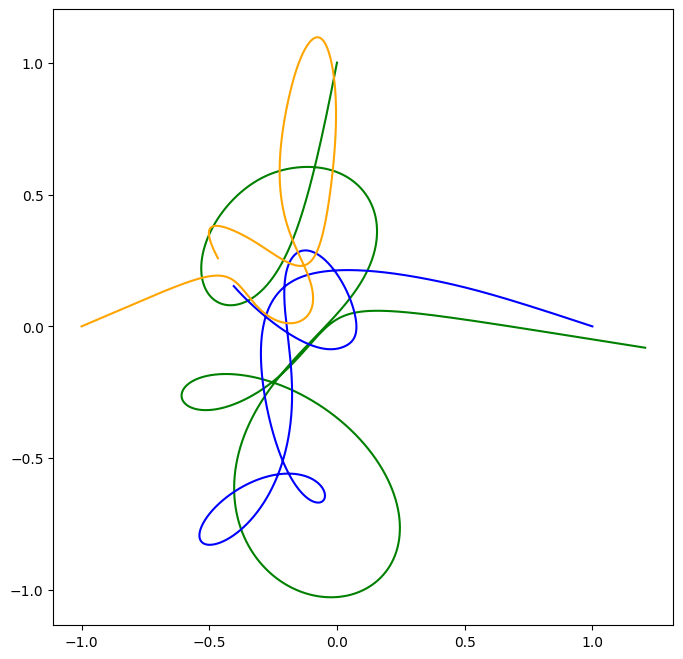

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

paths = rk_track[0].reshape(-1, 3, 2)[cut, :, :]
ax.plot(paths[:, 0, 0], paths[:, 0, 1], color="green")
ax.plot(paths[:, 1, 0], paths[:, 1, 1], color="blue")
ax.plot(paths[:, 2, 0], paths[:, 2, 1], color="orange")

# paths = yoshida4_track[1].reshape(-1, 3, 2)[cut, :, :]
# ax.plot(paths[:, 0, 0], paths[:, 0, 1], color="green", linestyle="--")
# ax.plot(paths[:, 1, 0], paths[:, 1, 1], color="blue", linestyle="--")
# ax.plot(paths[:, 2, 0], paths[:, 2, 1], color="orange", linestyle="--")

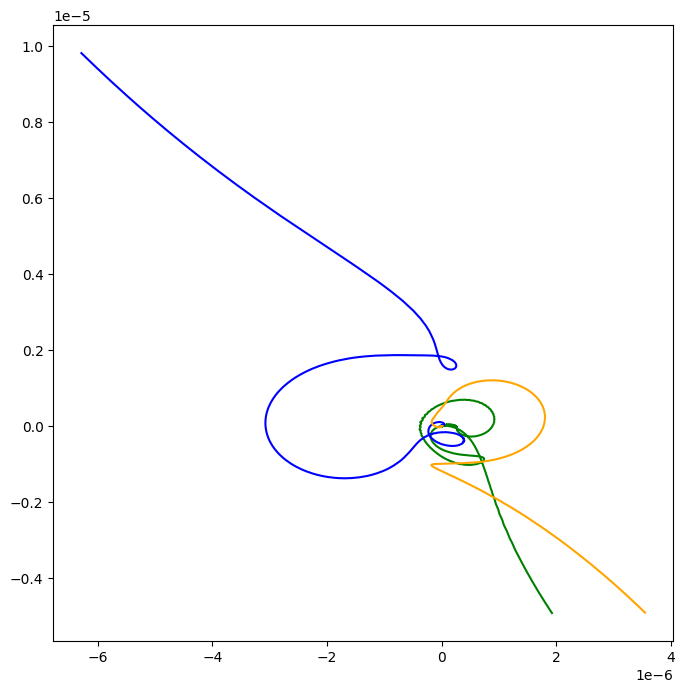

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

dpath = (rk_track[0] - yoshida4_track[0]).reshape(-1, 3, 2)[cut, :, :]
ax.plot(dpath[:, 0, 0], dpath[:, 0, 1], color="green")
ax.plot(dpath[:, 1, 0], dpath[:, 1, 1], color="blue")
ax.plot(dpath[:, 2, 0], dpath[:, 2, 1], color="orange")

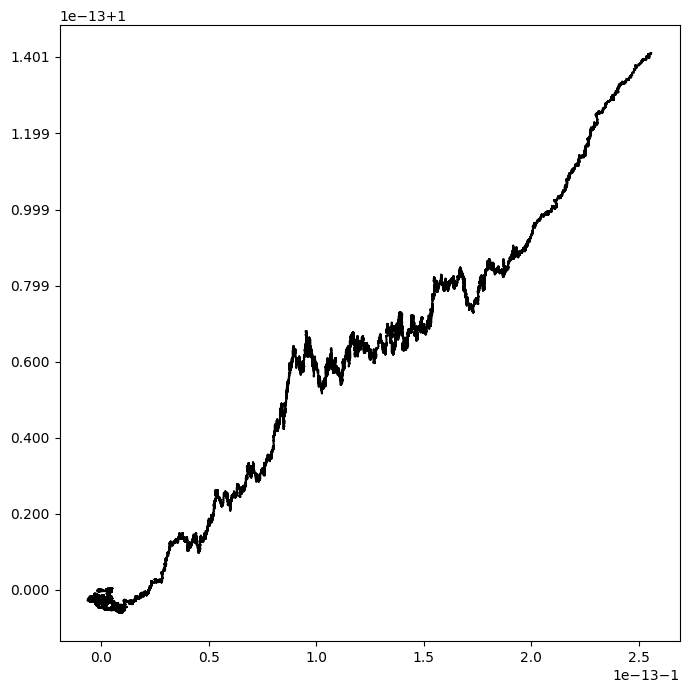

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

cmpath = jnp.sum(ruth3_track[0].reshape(-1, 3, 2)[cut, :, :] * mass0[:, None], axis=1)
ax.plot(cmpath[:, 0], cmpath[:, 1], color="k")

In [16]:
def func(mass):
    q, p, H = symplectic_integrator(lambda s: hamiltonian(s, mass), state0, times, ruth3_config)
    # rk crashes!
    # q, p, H = rk_integrator(lambda s: hamiltonian(s, mass), state0, times)
    return q, p, H

qdot, pdot, Hdot = jax.jacfwd(func)(mass0)
%timeit symplectic_integrator(hamiltonian_mass0, state0, times, ruth3_config)
%timeit jax.jacfwd(func)(mass0)

13.6 ms ± 68.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
704 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


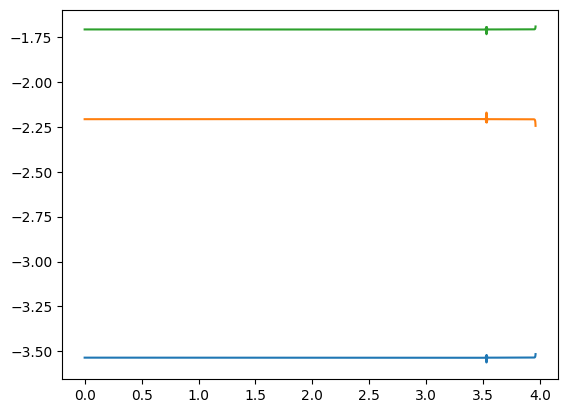

In [17]:
plt.plot(times[cut], Hdot[cut])

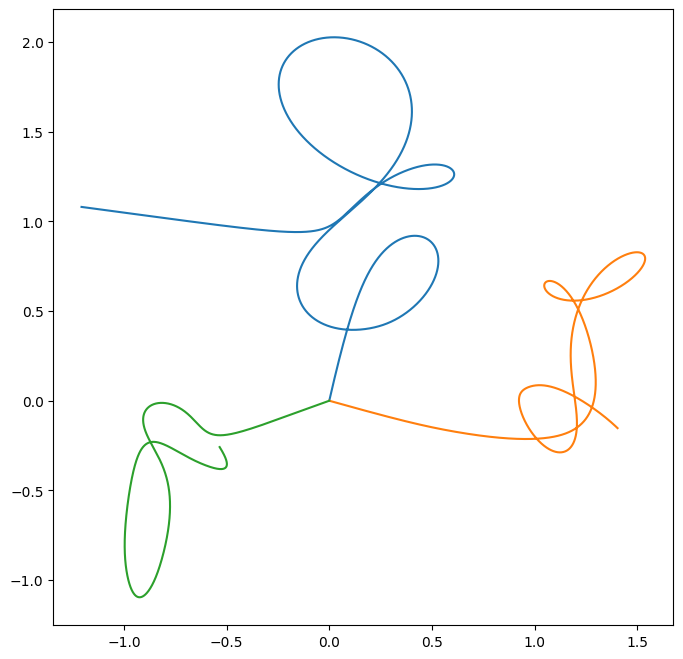

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))

cmpath = jnp.sum(qdot.reshape(-1, 3, 2, 3)[cut, :, :, :] * mass0[:, None, None], axis=1)
ax.plot(cmpath[:, 0, 0], cmpath[:, 1, 0])
ax.plot(cmpath[:, 0, 1], cmpath[:, 1, 1])
ax.plot(cmpath[:, 0, 2], cmpath[:, 1, 2])

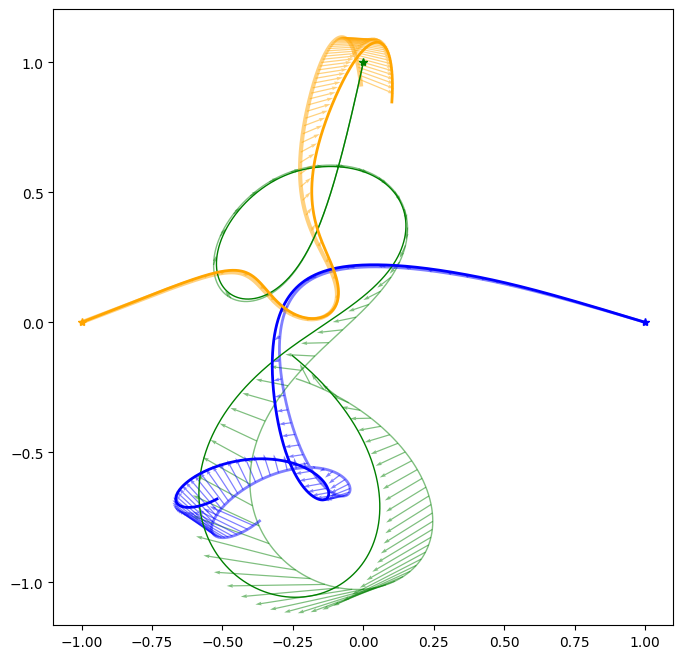

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

k = 15_000
paths = ruth3_track[0].reshape(-1, 3, 2)[cut, :, :][:k]
dpath_dm0 = qdot.reshape(-1, 3, 2, 3)[cut, :, :, 0][:k]

dm = 0.05
qnew = symplectic_integrator(lambda s: hamiltonian(s, mass0 + jnp.array([dm, 0.0, 0.0])), state0, times, ruth3_config)[0].reshape(-1, 3, 2)[:k]

n = 150
ax.plot(paths[:, 0, 0], paths[:, 0, 1], lw=mass0[0], alpha=0.5, color="green")
ax.plot(paths[:, 1, 0], paths[:, 1, 1], lw=mass0[1], alpha=0.5, color="blue")
ax.plot(paths[:, 2, 0], paths[:, 2, 1], lw=mass0[2], alpha=0.5, color="orange")
ax.plot(paths[0, 0, 0], paths[0, 0, 1], marker="*", color="green")
ax.plot(paths[0, 1, 0], paths[0, 1, 1], marker="*", color="blue")
ax.plot(paths[0, 2, 0], paths[0, 2, 1], marker="*", color="orange")

fig.savefig("three_body.png")

scale = 1 / dm
ax.quiver(paths[::n, 0, 0], paths[::n, 0, 1], dpath_dm0[::n, 0, 0], dpath_dm0[::n, 0, 1], color="green", width=0.002, alpha=0.5, scale_units="xy", scale=scale)
ax.quiver(paths[::n, 1, 0], paths[::n, 1, 1], dpath_dm0[::n, 1, 0], dpath_dm0[::n, 1, 1], color="blue", width=0.002, alpha=0.5, scale_units="xy", scale=scale)
ax.quiver(paths[::n, 2, 0], paths[::n, 2, 1], dpath_dm0[::n, 2, 0], dpath_dm0[::n, 2, 1], color="orange", width=0.002, alpha=0.5, scale_units="xy", scale=scale)
fig.savefig("three_body_dm3.png")

ax.plot(qnew[:, 0, 0], qnew[:, 0, 1], lw=mass0[0], color="green")
ax.plot(qnew[:, 1, 0], qnew[:, 1, 1], lw=mass0[1], color="blue")
ax.plot(qnew[:, 2, 0], qnew[:, 2, 1], lw=mass0[1], color="orange")
fig.savefig("three_body_dm3new.png")


In [20]:
# validate bias by simulating many initial conditions
# and computing derivatives and comparing with finite differences